# Using TfidfVectorizer instead of CountVectorizer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from wordcloud import WordCloud

import os
import gdown


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
url = 'https://drive.google.com/uc?export=download&id=1gy_xg86ieyPvzx5MSwJjKzvC_cp7CUcv'
output = 'reviews_dataset.csv'

if not os.path.exists(output):
    print(f"{output} does not exist. Downloading...")
    gdown.download(url, output, quiet=False)
else:
    print(f"{output} already exists. Skipping download.")



reviews_dataset.csv already exists. Skipping download.


Load dataset - We will be using Amazon fine foods review dataset to train and test the model

In [3]:
data = pd.read_csv('reviews_dataset.csv')

# dataset overview
print(data.shape)
print(data['Score'].value_counts())

(568454, 10)
Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64


In [4]:
# remove neutral reviews -- score == 3
data = data[data['Score'] != 3]

# label
data['Positivity'] = np.where(data['Score'] > 3, 1, 0)

# overview the labeled data
print(data['Positivity'].value_counts())

Positivity
1    443777
0     82037
Name: count, dtype: int64


In [5]:
data_majority = data[data['Positivity'] == 1]
data_minority = data[data['Positivity'] == 0]


data_majority_downsampled = resample(data_majority, 
                                     replace=False,    
                                     n_samples=len(data_minority), 
                                     random_state=42) 

data = pd.concat([data_minority, data_majority_downsampled])

# check data proportion
print(data['Positivity'].value_counts())

Positivity
0    82037
1    82037
Name: count, dtype: int64


In [6]:
data = data.drop(['ProductId','UserId','ProfileName','Id','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time','Summary'], axis=1)
print(data.shape)

(164074, 2)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Positivity'], random_state = 0)

In [8]:
print('X_train shape: ', X_train.shape)
print("X_test shape",X_test.shape)

X_train shape:  (123055,)
X_test shape (41019,)


### TF IDF (term-frequency-inverse-document-frequency).

In [9]:
# ignore terms that appear in less than 5 documents
vect = TfidfVectorizer(min_df = 5, ngram_range=(1, 3)).fit(X_train)
len(vect.get_feature_names_out())

514827

### Transforming into Bag of words representation

Store in a matrix form

In [10]:
X_train_vectorized = vect.transform(X_train)

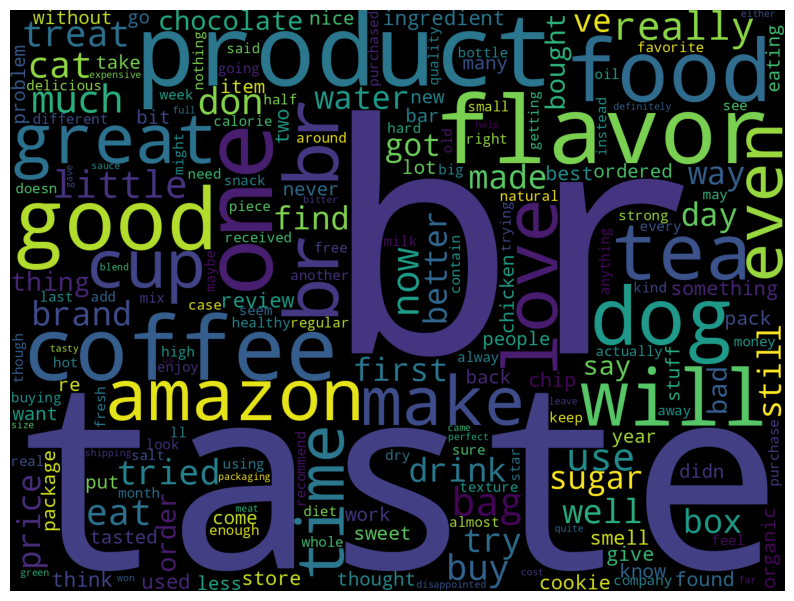

In [11]:
feat = vect.get_feature_names_out()
cloud = WordCloud(width=1440, height=1080).generate(" ".join(feat))

plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

### Train the model and calculate accuracy

In [12]:

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(X_test))
print("Accuracy: ",accuracy_score(y_test, predictions))



Accuracy:  0.9361027816377776


###  Area Under the Receiver Operating Characteristic Curve (ROC AUC)
assessing the performance of our binary classification model using logistic regression

AUC:  0.9362136483006306


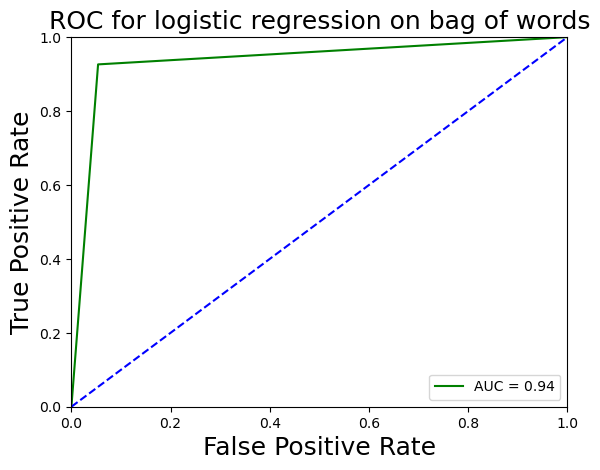

In [13]:

roc_auc = roc_auc_score(y_test, predictions)
print('AUC: ', roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)

plt.title('ROC for logistic regression on bag of words', fontsize=18)
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize = 18)
plt.xlabel('False Positive Rate', fontsize = 18)
plt.show()

In [14]:
# Top 10 positive and negative words

# getting the feature names
feature_names = np.array(vect.get_feature_names_out())

# argsort: Integer indicies that would sort the index if used as an indexer
sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['not' 'disappointed' 'terrible' 'awful' 'unfortunately' 'worst'
 'horrible' 'disappointing' 'stale' 'bad']

Largest Coefs: 
['great' 'delicious' 'good' 'perfect' 'excellent' 'love' 'the best' 'best'
 'loves' 'wonderful']



In [15]:
new_review = ['The food was delicious', 'not bad at all', 'worse','best','great','bad']
print()
discrete = model.predict(vect.transform(new_review))
probabilities = model.predict_proba(vect.transform(new_review))

for review, ans, probability in zip(new_review, discrete, probabilities):
    print( f'The review {review} :  {ans} : is positive with probability {probability[1]} ')


The review The food was delicious :  1 : is positive with probability 0.8949222523339848 
The review not bad at all :  0 : is positive with probability 0.11587377683853288 
The review worse :  0 : is positive with probability 0.0065615957962596215 
The review best :  1 : is positive with probability 0.9996440768067426 
The review great :  1 : is positive with probability 0.999999931799106 
The review bad :  0 : is positive with probability 0.0011179801148476914 
